In [1]:
# include controllers to the path
import sys, os
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), 'controllers'))

# include pipeline repo to compute performance
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', 'pipeline'))
sys.path.append(os.path.join(os.getcwd(), '..', 'pipeline', 'postprocessing'))

import cv2
import threading
import math
import time
import random
import json
import datetime
import os, shutil
import numpy as np
import multiprocess as mp

# controllers
import nbimporter
from controllers.situtils import FPSTimes
from controllers.camera import WebcamStream
from controllers.video import VideoWriter
from controllers.position import PositionTrackerSingle, PositionTrackerDouble
from controllers.sound import SoundController, ContinuousSoundStream
from controllers.serial import MCSArduino, FakeArduino, SpeakerMotor, CableMotor
from controllers.display import SITDisplay

from pipeline.postprocessing.pack import pack
from pipeline.postprocessing.performance import calculate_performance, dump_performance_to_H5

## Load experiment settings

For every experimental cofiguration you can copy the original 'settings.json' file, build your own specific experimental preset, save it in this folder as e.g. 'settings_elena.json' and load it here instead of 'settings.json'.

In [2]:
cfg_filename = os.path.join('profiles', 'gokce_timeSIT_50_55.json')
cfg_filename = os.path.join('profiles', 'andrey_hippoSIT_fixed.json')

In [3]:
with open(os.path.join('profiles', 'default.json')) as json_file:
    cfg = json.load(json_file)
with open(cfg_filename) as json_file:
    cfg_local = json.load(json_file)

for key in cfg.keys():
    cfg[key].update(cfg_local[key])
cfg['experiment']['experiment_date'] = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# print loaded settings
#print(json.dumps(cfg, indent=4))

In [4]:
# check if the sound interface is there
import sounddevice as sd
asio = [x for x in sd.query_devices() if x['name'].find('ASIO') > 0]
#if len(asio) == 0:
#    raise SystemExit('The sound interface is not found. Please restart the computer')

## Initialize session folder

Run the upcoming cell, to create a session folder and to save the chosen experimetal parameters to a JSON-file ("experiment_id_parameters.json"). The session folder will be created here where this notebook is located.

In [5]:
# This session's protocols will be saved to this folder
cfg_exp = cfg['experiment']
experiment_id = "%s_%s_%s" % (cfg_exp['subject'], cfg_exp['experiment_type'], cfg_exp['experiment_date'])
save_to = os.path.join('sessions', experiment_id)
             
if not os.path.exists(save_to):
    os.makedirs(save_to)

# update paths (assuming this paths are relative to this notebook)
cfg['video']['file_path'] = os.path.join(save_to, cfg['video']['file_path'])
cfg['position']['file_path'] = os.path.join(save_to, cfg['position']['file_path'])
cfg['position']['contour_path'] = os.path.join(save_to, cfg['position']['contour_path'])
cfg['experiment']['file_path'] = os.path.join(save_to, cfg['experiment']['file_path'])
cfg['experiment']['islands_path'] = os.path.join(save_to, 'islands.csv')
cfg['sound']['file_path'] = os.path.join(save_to, cfg['sound']['file_path'])
cfg['position']['background_light'] = os.path.join('assets', cfg['position']['background_light'])
cfg['position']['background_dark'] = os.path.join('assets', cfg['position']['background_dark'])
if not 'distractor_fail' in cfg['experiment']:
    cfg['experiment']['distractor_fail'] = False
if 'continuous' in cfg['sound']:
    cfg['sound']['continuous']['wav_file'] = os.path.join('assets', cfg['sound']['continuous']['wav_file'])
    
# Saves all parameters to a JSON file with the user-defined "Experiment ID" as filename
with open(os.path.join(save_to, experiment_id + '.json'), 'w') as f:
    json.dump(cfg, f, indent=4)
    
with open(cfg['experiment']['file_path'], 'w') as f:
    # state: 0 - trial start, 1 - trial success, 2 - trial fail
    f.write('time, target_x, target_y, target_r, trial, state\n')

with open(cfg['experiment']['islands_path'], 'w') as f:
    f.write('tgt_x, tgt_y, tgt_r, d1_x, d1_y, d1_r, d2_x, d2_y, d2_r, d3_x, d3_y, d3_r\n')

In [6]:
class Island:    
    def __init__(self, x, y, radius, sound_id, is_distractor=False):
        self.x = x  # in meters
        self.y = y  # in meters
        self.r = radius  # in meters
        self.sound_id = sound_id
        self.is_distractor = is_distractor

    def __str__(self):
        return ",".join(["%.4f" % x for x in (self.x, self.y, self.r)] + [str(self.sound_id), "1" if self.is_distractor else "0"])        

In [7]:
def generate_islands(floor_radius, island_radius, distractors=0):
    def get_new_xy(new_islands):
        while True:
            # all in meters
            rho = np.sqrt(np.random.rand()) * (floor_radius - island_radius)
            phi = np.random.rand() * 2 * np.pi
            x = rho * np.sin(phi)
            y = rho * np.cos(phi)

            too_close = False
            for island in new_islands:
                if (island.x - x)**2 + (island.y - y)**2 < (2*island_radius)**2:
                    too_close = True
                    break
                    
            if too_close:
                continue
            return x, y
    
    # target island
    x, y = get_new_xy([])
    islands = [Island(x, y, island_radius, 2, False)]  # sound 2 is always target
    
    distr_ids = [k for k, v in cfg['sound']['sounds'].items() if k.find('distractor') > -1 and v['enabled']]
    sound_ids = [3 + i for i in range(len(distr_ids))]
    if distractors > 0:
        for i in range(distractors):
            x, y = get_new_xy(islands)
            islands.append(Island(x, y, island_radius, sound_ids.pop(random.randint(0, len(sound_ids)-1)), True))
    
    return islands  # always a list of Islands

In [8]:
def get_island_position(time_from_start, phi_initial, phi_max, timepoints=[600, 1200, 1800, 2400]):
    # returns the angle of the island (in polar coordinates)
    # all angles are in radians
    
    # no change during light periods
    if time_from_start <= timepoints[0] or time_from_start >= timepoints[-1]:
        return phi_initial
    
    # max anglular conflict in the middle of the dark
    if time_from_start >= timepoints[1] and time_from_start <= timepoints[2]:
        return phi_initial + phi_max
    
    # raising phase
    if time_from_start < timepoints[1]:
        p_dur = timepoints[1] - timepoints[0]
        t_in_p = time_from_start - timepoints[0]
        return phi_initial + phi_max * (t_in_p/p_dur)
        
    # falling phase
    p_dur = timepoints[3] - timepoints[2]
    t_in_p = time_from_start - timepoints[2]
    return phi_initial + phi_max * (1 - (t_in_p/p_dur))

In [9]:
def timeout(t_start):
    return time.time() - t_start > cfg_exp['session_duration'] if t_start is not None else False

In [10]:
def log_event(*args):  # log start / end of a trial
    with open(cfg_exp['file_path'], 'a') as f:
        f.write(",".join([str(x) for x in args]) + "\n")

In [11]:
def log_islands(islands):  # log position of the islands
    sorted_islands = sorted(islands, key=lambda x: x.sound_id, reverse=False)
    args = [(i.x, i.y, i.r) for i in sorted_islands]
    to_dump = [x for xs in args for x in xs]
        
    with open(cfg_exp['islands_path'], 'a') as f:    
        f.write(",".join([str(round(x, 4)) for x in to_dump]) + "\n")

In [12]:
def switch_light(pt, board):
    pt.switch_background()
    board.switch_light()

## Start the experiment

This cell contains code for animal tracking. We hope that the comments provided in the code suffice to understand the individual steps and to adjust them to your own setup and needs, if necessary.

- press 's' to start recording
- press 's' again to stop recording
- press 'q' to quit

The experiment will stop automatically if the pre-defined session duration is reached.

In [13]:
# actual sound selector: -1 - noise, 0 - silence, 1 - foraging, 2 - target, 3 - distractor
sound = mp.Value('i', 1)
if 'noise_when_idle' in cfg_exp and cfg_exp['noise_when_idle']:
    sound.value = -1

# experiment status: 1 - idle, 2 - running (recording, logging), 0 - stopped
status = mp.Value('i', 1)

# init the sync with the acquisition system and feeder via Arduino
if cfg['experiment']['MCSArduinoPort'] == 'fake':
    board = FakeArduino()
else:
    board = MCSArduino(cfg['experiment']['MCSArduinoPort'])

# init speaker motor control
if 'motors_port' in cfg['experiment'] and cfg['experiment']['enable_motors']:
    motor_board = SpeakerMotor(cfg['experiment']['motors_port'])
    
# init ephys cable rotation motor
if 'cable_motor_port' in cfg['experiment']:
    cable_board = CableMotor(cfg['experiment']['cable_motor_port'])

# init continuous sound, if required
if 'continuous' in cfg['sound']:
    cst = ContinuousSoundStream(cfg['sound']['continuous'])
    cst.start()
    
# start the camera stream
vs = WebcamStream(cfg['camera'])
vs.start()

# init video recorder
vw = VideoWriter(status, vs, cfg['video'])
vw.start()

# start position tracking
pt = PositionTrackerSingle(status, vs, cfg['position']) if cfg['position']['single_agent'] else PositionTrackerDouble(status, vs, cfg['position'])
pt.start()

# init frame renderer
dc = SITDisplay(pt)

# playing sound in a separate process for performance
sc = mp.Process(target=SoundController.run, args=(sound, status, cfg['sound']))
sc.start()

timers = []
fps = FPSTimes()
names = ['camera', 'video', 'position', 'main']
distr_count = cfg['experiment']['distractor_islands']
trial = 0
rewards = 0
t_start = None
target_since = None
distractor_since = None
punishment_since = None
trial_start = time.time()
phase = 0  # 0 - idle, 1 - foraging, 2 - inter-trial interval
cfg_exp = cfg['experiment']
cfg_pos = cfg['position']
islands = []

# initial position of the island, if set
phi_initial = np.random.rand() * 2 * np.pi if cfg_exp['target_angle'] == 'random' else np.deg2rad(int(cfg_exp['target_angle']))
rho = pt.cfg['floor_radius'] * pt.pixel_size - cfg_exp['target_radius']  # constant, in meters
iti_distance = 0.0
last_x, last_y = None, None

# inaudible island trial profiles
max_trials = 200
p0 = np.array([0 for x in range(max_trials)])                          # never
p1 = np.array([0 if (x+1) % 4 > 0 else 1 for x in range(max_trials)])  # every 4-th trial
p2 = np.array([0 if (x+1) % 2 > 0 else 1 for x in range(max_trials)])  # every 2-nd trial
p3 = np.array([1 if x % 4 > 0 else 0 for x in range(max_trials)])      # always except every 4-th trial
unaudible_trials = np.vstack([p0, p1, p2, p3])

## TODO refactor a) trial init, b) trial failure and c) trial success as separate functions - read about state mgmt

try:
    while trial <= cfg_exp['trial_number'] and not timeout(t_start):
        
        # ---------- rendering logic -----------
        frame = vs.read()
        if frame is None:
            time.sleep(0.1)
            continue # wait for the stream
            
        c_time = time.time()
        fps.count()
        angles, text_infos = [], []
        
        if not cfg_exp['target_angle'] == 'random':
            angles = [pt.correct_angle(phi_initial), pt.correct_angle(phi_initial + np.deg2rad(cfg_exp['phi_max']))]
        
        for i, ctrl in enumerate([vs, vw, pt, fps]):  # FPS indicators
            text_infos.append('%s: %.2f FPS' % (names[i], ctrl.get_avg_fps()))
        
        if len(islands) > 0:  # target island X, Y
            target = [i for i in islands if not i.is_distractor][0]
            text_infos.append('Target: %.3f %.3f' % (target.x, target.y))
            
        text_infos.append('Time: %.2f' % float(c_time - t_start) if t_start is not None else 'Time: Idle')  # stopwatch
        text_infos.append('Trial: %.2f' % float(cfg_exp['trial_duration'] - (c_time - trial_start)) if phase == 1 else 'Trial: not started')
        text_infos.append('Trial: %s' % trial)
        text_infos.append('Rewards: %s' % rewards)  # rewards
        text_infos.append('In target: %.2f' % float(c_time - target_since) if target_since is not None else 'In target: --')
        text_infos.append('ITI distance: %.2f' % iti_distance if iti_distance > 0 else 'ITI distance: --')

        frame, frame_to_save = dc.render(frame, status, islands=islands, angles=angles, text_infos=text_infos)
            
        # assign the frame back to the video stream for other controllers
        vs.frame_with_infos = frame_to_save
        
        cv2.imshow('Press (s)-to start/stop, (q)-to end', frame)

        # -------- experiment logic ---------------
        
        # animals is either foraging (phase == 1) or in the inter-trial-interval (phase == 2)
        if phase == 1: # foraging
            if pt.positions_in_m is not None and len(islands) > 0:
                # check if animal in the island and for how long
                tgt = [i for i in islands if not i.is_distractor][0]
                distractors = [i for i in islands if i.is_distractor]
                
                if pt.is_inside(tgt.x, tgt.y, cfg_exp['target_radius']):
                    if target_since is None:  # just entered target
                        target_since = c_time
                        if unaudible_trials[cfg_exp['unaudible_profile']][trial - 1] == 0:
                            sound.value = 2

                    elif c_time - target_since > cfg_exp['target_duration']: # successful trial
                        log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 1) # log trial success
                        board.feed()
                        
                        # init inter-trial interval and new trial
                        trial_start = c_time + cfg_exp['iti_duration'] + 5 * np.random.rand()  # random b/w 20-25 sec
                        sound.value = 0  # silence
                        islands = []
                        phase = 2
                        rewards += 1
                        target_since = None
                        
                elif c_time - trial_start > cfg_exp['trial_duration']:  # trial failed and animal is not in the target
                    ## TODO refactor this + trial fail below into a function
                    log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 2) # log trial failed because of time
                    trial_start = c_time + cfg_exp['iti_duration'] + 5 * np.random.rand()  # random b/w 10-15 sec
                    sound.value = -1  # punishment
                    punishment_since = c_time
                    islands = []
                    phase = 2
                    distractor_since = None
                
                else:
                    target_since = None
                    in_distractor = False
                    
                    for isl in distractors:  # maybe animal is in one of the distractors
                        if pt.is_inside(isl.x, isl.y, cfg_exp['target_radius']):
                            if distractor_since is None:  # just entered distractor
                                distractor_since = c_time
                                
                            sound.value = isl.sound_id
                            in_distractor = True
                            
                            if c_time - distractor_since > cfg_exp['target_duration'] and cfg_exp['distractor_fail']:
                                # fail trial because in distractor
                                log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 2) # log trial failed
                                trial_start = c_time + cfg_exp['iti_duration'] + 5 * np.random.rand()  # random b/w 10-15 sec
                                sound.value = -1  # punishment
                                punishment_since = c_time
                                islands = []
                                phase = 2
                                distractor_since = None
                        else:
                            distractor_since = None
                    
                    if not in_distractor:  # outside of the islands
                        sound.value = 1
            
        elif phase == 2:  # inter-trial-interval
            # count distance between trials
            if last_x is None:
                last_x, last_y = pt.positions_in_m[0]
            else:
                x, y = pt.positions_in_m[0]
                iti_distance += np.sqrt((x - last_x)**2 + (y - last_y)**2)
                last_x, last_y = x, y
            
            # reset punishment sound
            if punishment_since is not None and c_time - punishment_since > cfg_exp['punishment_duration']:
                sound.value = 0
                punishment_since = None

            phi = get_island_position(c_time - t_start, phi_initial, np.deg2rad(cfg_exp['phi_max']), cfg_exp['timepoints'])
            phi = pt.correct_angle(phi)  # correct for the camera orientation
            x_tgt, y_tgt = rho * np.sin(phi), rho * np.cos(phi)

            if c_time > trial_start and iti_distance > cfg_exp['iti_distance'] and \
                    not pt.is_inside(x_tgt, y_tgt, cfg_exp['target_radius']):
                ## TODO refactor this + trial init below into a function
                # init_new_trial
                if cfg_exp['target_angle'] == 'random':
                    islands = generate_islands(cfg_pos['floor_r_in_meters'], cfg_exp['target_radius'], distr_count)
                else:  # fixed angle protocol
                    islands = [Island(x_tgt, y_tgt, cfg_exp['target_radius'], 2)]
                log_islands(islands)  # log island(s) positions
                sound.value = 1
                phase = 1
                trial += 1
                
                # reset ITI distance and trial_start
                iti_distance = 0
                trial_start = c_time
                
                # log trial start
                tgt = [i for i in islands if not i.is_distractor][0]
                log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 0)
        
        # -------- key press events ---------------
        
        k = cv2.waitKey(33)
        
        # light on/off
        if k == ord('l'):
            switch_light(pt, board)
        
        # motors
        if k == ord('d'):
            if cfg['experiment']['enable_motors']:
                motor_board.switch_diodes()
         
        # disable motor control for safety
        #if k == ord('t'):
        #    tm = threading.Timer(20, motor_board.rotate, args=(False, 90, 30))
        #    tm.start()
        #    #motor_board.rotate(False, 90, 30)
        #if k == ord('r'):
        #    tm = threading.Timer(20, motor_board.rotate, args=(True, 90, 30))
        #    tm.start()
        
        # ephys cable on top
        if k == ord('i') and 'cable_motor_port' in cfg['experiment']:
            tf = threading.Timer(0, cable_board.turn_CCW, args=[])
            tf.start()
        if k == ord('o') and 'cable_motor_port' in cfg['experiment']:
            tf = threading.Timer(0, cable_board.turn_CW, args=[])
            tf.start()
            
        # feeding
        if k == ord('f'):
            tf = threading.Timer(0, board.feed, args=[])
            tf.start()

        if k == ord('c'):
            f_name = cfg_pos['background_light'] if pt.is_light else cfg_pos['background_dark']
            cv2.imwrite(f_name, dc.masked_frame)
            tf = threading.Timer(0.2, pt.reload_background, args=[])
            tf.start()            

        # quit the session
        if k == ord('q'):
            break

        # start the experiment
        if k == ord('s'):
            board.start_or_stop()  # start/stop data acquisition
            c_time = time.time()   # more accurate time
            
            if cfg['experiment']['enable_motors']:
                if not motor_board.diodes_on:
                    motor_board.switch_diodes()

            if status.value == 1: # start the session
                if t_start is None:
                    t_start = c_time
                trial_start = c_time
                status.value = 2
                
                # init_new_trial
                phi = get_island_position(c_time - t_start, phi_initial, np.deg2rad(cfg_exp['phi_max']), cfg_exp['timepoints'])
                phi = pt.correct_angle(phi)  # correct for the camera orientation
                x_tgt, y_tgt = rho * np.sin(phi), rho * np.cos(phi)
                if cfg_exp['target_angle'] == 'random':
                    islands = generate_islands(cfg_pos['floor_r_in_meters'], cfg_exp['target_radius'], distr_count)
                else:  # fixed angle protocol                
                    islands = [Island(x_tgt, y_tgt, cfg_exp['target_radius'], 2)]
                log_islands(islands)  # log island(s) positions
                sound.value = 1
                phase = 1
                trial += 1

                # log trial start
                tgt = [i for i in islands if not i.is_distractor][0]
                log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 0)
                
                # init light events
                timers = []
                for event_t in cfg_exp['light_events']:
                    timers.append(threading.Timer(event_t, switch_light, args=(pt, board)))
                    
                if cfg['experiment']['enable_motors']:
                    if not cfg['experiment']['phi_max'] == 0:
                        direction = False if cfg['experiment']['phi_max'] > 0 else True
                        t0, t1 = cfg['experiment']['timepoints'][0], cfg['experiment']['timepoints'][1]
                        timers.append(threading.Timer(t0, motor_board.rotate, args=(direction, abs(cfg['experiment']['phi_max']), t1-t0)))
                        t0, t1 = cfg['experiment']['timepoints'][2], cfg['experiment']['timepoints'][3]
                        timers.append(threading.Timer(t0, motor_board.rotate, args=(not direction, abs(cfg['experiment']['phi_max']), t1-t0)))
                    
                for t in timers:
                    t.start()
                
            elif status.value == 2:  # pause the session
                if len(islands) > 0:
                    tgt = [i for i in islands if not i.is_distractor][0]
                    x, y, r = round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4)
                else:
                    x, y, r = 0, 0, 0
                log_event(c_time, x, y, r, trial, -1)  # log experiment break
                
                if 'noise_when_idle' in cfg_exp and cfg_exp['noise_when_idle']:
                    sound.value = -1
                status.value = 1
                phase = 0
                islands = []
                for t in timers:
                    t.cancel()
                    
        if k == ord('a'):
            sound.value = -1 if sound.value >= 0 else 0
            switch_light(pt, board)  # turn lights off 

finally:
    if status.value == 2:  # stop data acquisition, in case exited via timeout
        board.start_or_stop()
        if len(islands) > 0:
            tgt = [i for i in islands if not i.is_distractor][0]
            x, y, r = round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4)
        else:  
            x, y, r = 0, 0, 0
        log_event(c_time, x, y, r, trial, -1)  # log experiment end
        
    status.value = 0
    time.sleep(0.01)
    for t in timers:
        t.cancel()
    
    if board.is_light_off:
        board.switch_light()  # turn light back on
        time.sleep(0.1)
    board.exit()
    
    if cfg['experiment']['enable_motors']:
        if motor_board.diodes_on:
            motor_board.switch_diodes()
        motor_board.exit()
    if 'cable_motor_port' in cfg['experiment']:
        cable_board.exit()
    
    cv2.destroyAllWindows()
    sc.join()
    for ctrl in [pt, vw, vs]:
        ctrl.stop()

    if 'continuous' in cfg['sound']:
        time.sleep(cfg['sound']['continuous']['end_sleep'])
        cst.stop()

Continuous sound stream started at 48000 Hz
Webcam stream 1024.0:768.0 at 30.00 FPS started
Position tracker stopped
Video writer stopped
Camera released
Continuous sound stream released


### Merge data in HDF5 file

In [14]:
session_path = save_to
#session_path = os.path.join('sessions', '2021-07-30_09-24-14')  # some particular session
#session_path = 'Y:\\Michael\\FreeBehaving\\SIT_sessions\\50_aSIT_2021-10-25_10-32-19'

In [15]:
if not trial > 0:
    raise SystemExit('Nothing recorded. No sense to continue.')

# do pack data to HDF5
h5name = pack(session_path)
trial = 0

### Plot sessions stats

In [16]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy import signal

In [17]:
arena_r = 0.46  # in meters

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    trial_idxs = np.array(f['processed']['trial_idxs'])

Text(0.5, 1.0, 'Speed')

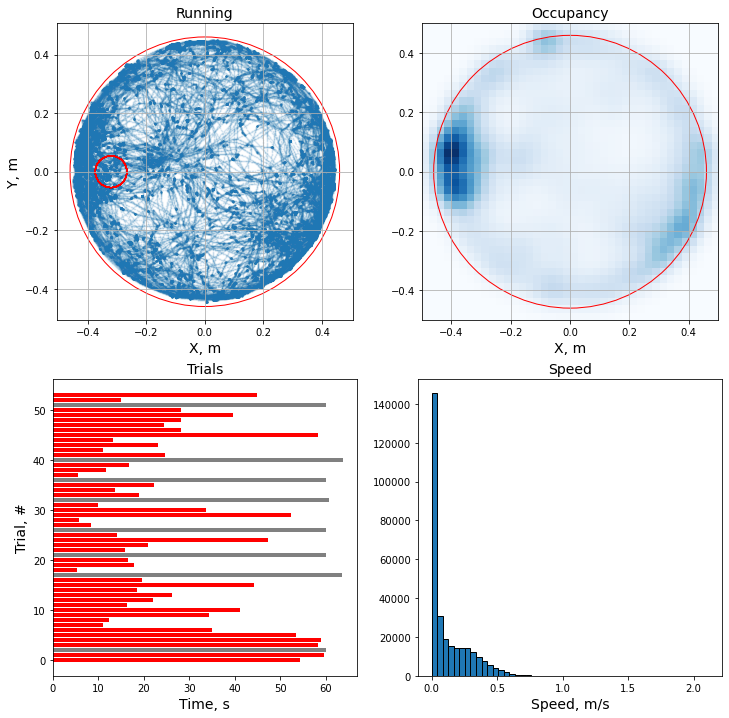

In [18]:
fig = plt.figure(figsize=(12, 12))

# trajectory and islands
ax = fig.add_subplot(221)
ax.scatter(tl[:, 1], tl[:, 2], s=1, alpha=0.1)  # positions
scat = ax.scatter(trial_idxs[:, 2], trial_idxs[:, 3], s=1000, facecolors='none', edgecolors='r')  # islands, radius approx.
ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
ax.set_aspect('equal')
ax.set_xlabel('X, m', fontsize=14)
ax.set_ylabel('Y, m', fontsize=14)
ax.set_title('Running', fontsize=14)
ax.grid()

# occupancy
sigma = 0.1
lin_profile = np.linspace(-15, 15, 20)
bump = np.exp(-sigma * lin_profile**2)
bump /= np.trapz(bump)  # normalize to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
occupancy_map, _, _ = np.histogram2d(tl[:, 1], tl[:, 2], bins=[40, 40], range=np.array([[-0.5, 0.5], [-0.5, 0.5]]))
occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

ax = fig.add_subplot(222)
ax.imshow(occupancy_map.T, origin='lower', extent=(-0.5, 0.5, -0.5, 0.5), cmap='Blues')
ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
ax.set_xlabel('X, m', fontsize=14)
ax.set_title('Occupancy', fontsize=14)
ax.grid()

# trials
durations = tl[trial_idxs[:, 1].astype(int)][:, 0] - tl[trial_idxs[:, 0].astype(int)][:, 0]
colors = ['red' if x == 1 else 'grey' for x in trial_idxs[:, 5]]

ax = fig.add_subplot(223)
ax.barh(np.arange(len(trial_idxs)), durations, color=colors, align='center')
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Trial, #', fontsize=14)
ax.set_title('Trials', fontsize=14)

# speed
ax = fig.add_subplot(224)
ax.hist(tl[:, 3], bins=50, ec='black')
ax.set_xlabel('Speed, m/s', fontsize=14)
ax.set_title('Speed', fontsize=14)

## Performance

In [19]:
h5name = os.path.join(session_path, experiment_id + '.h5')
jsname = os.path.join(session_path, experiment_id + '.json')

# loading position and trial data
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
    trial_idxs = np.array(f['processed']['trial_idxs'])  # idx start, idx end, X, Y, R, trial result (idx to tl)

# loading session configuration
with open(jsname, 'r') as f:
    cfg = json.load(f)

timepoints = cfg['experiment']['timepoints']
s_duration = cfg['experiment']['session_duration']

periods = [[0, s_duration], [0, timepoints[0]], [timepoints[1], timepoints[2]], [timepoints[3], s_duration]]

# separate ALL, L, D, L'
ds_names = ['performance_ALL', 'performance_L', 'performance_D', 'performance_Lp']
ds_names = ['performance_ALL']  # only light

for i, ds_name in enumerate(ds_names):
    t_start, t_end = periods[i]
    trial_starts = tl[trial_idxs[:, 0].astype(np.int32)][:, 0]
    trial_ends   = tl[trial_idxs[:, 1].astype(np.int32)][:, 0]
    tr_idxs = trial_idxs[(trial_starts >= t_start) & (trial_ends <= t_end)]

    dataset = calculate_performance(tl, tr_idxs, cfg)
    dump_performance_to_H5(h5name, ds_name, dataset)

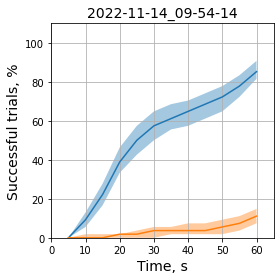

In [20]:
fig = plt.figure(figsize=(4, 4))

with h5py.File(h5name, 'r') as f:
    perf = np.array(f['analysis']['performance_ALL'])
    x = perf[:, 6]

ax = fig.add_subplot(111)

ax.plot(x, perf[:, 0])  # performance
ax.plot(x, perf[:, 3])  # chance
ax.fill_between(x, perf[:, 0] + perf[:, 1], perf[:, 0] + perf[:, 2], alpha=0.4)
ax.fill_between(x, perf[:, 3] + perf[:, 4], perf[:, 3] + perf[:, 5], alpha=0.4)
ax.set_ylim(0, 110)
ax.set_xlim(0, 65)
ax.grid()
ax.set_title(experiment_id[-19:], fontsize=14)
ax.set_xlabel('Time, s', fontsize=14)

if i == 0:
    ax.set_ylabel('Successful trials, %', fontsize=14)
        
fig.tight_layout()